In [1]:
import os, random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# import InterfacePreprocessing as IntPre

from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from sklearn.metrics import roc_curve, auc
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def generate_batch_mnist(n, mode='train'):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        if mode == 'train':
            batch = mnist.train.next_batch(2, )
        elif mode == 'test':
            batch = mnist.test.next_batch(2)
        else:
            batch = mnist.validation.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]  

def batch_mnist(n, mode='train'):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    y_label = np.zeros((n,10))
    y_p_label = np.zeros((n,10))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        if mode == 'train':
            batch = mnist.train.next_batch(2, )
        elif mode == 'test':
            batch = mnist.test.next_batch(2)
        else:
            batch = mnist.validation.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            y_label[matched,:] = batch[1][0]
            y_p_label[matched,:] = batch[1][1]
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            y_label[-mismatched,:] = batch[1][0]
            y_p_label[-mismatched,:] = batch[1][1]
            mismatched -= 1
            
    return [x, x_p, y, y_label, y_p_label]  

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

# 1 - output 14*14*20

W_conv1 = weight_variable([7, 7, 1, 20])
b_conv1 = bias_variable([20])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2 - output 7*7*80

W_conv2 = weight_variable([5, 5, 20, 40])
b_conv2 = bias_variable([40])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 3 - output 4*4*320

W_conv3 = weight_variable([5, 5, 40, 80])
b_conv3 = bias_variable([80])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# fc

W_fc1 = weight_variable([4*4*80, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*80])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


h_fc1_flat = tf.reshape(h_fc1, [-1,1024])
h_fc1_norm = tf.sqrt(tf.reduce_sum(tf.square(h_fc1_flat)))

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Working Code of plain simple training for digit classification

Test accuracy around 95%

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

trainlab = tf.argmax(y_,1)
predlab = tf.argmax(y_conv,1)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i%25 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
#         print trainlab.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})[0:10], predlab.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})[0:10]
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

# Save and read state for simple digit classification

In [ ]:
saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

# Later, launch the model, initialize the variables, do some work, save the
# variables to disk.
with tf.Session() as sess:
    sess.run(init_op)
    
    # Do some work with the model.
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    sess.run(tf.initialize_all_variables())
    
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print("test accuracy %g"%accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
    # Save the variables to disk.
    
    save_path = saver.save(sess, "one_sided.ckpt")
    print("Model saved in file: %s" % save_path)

In [ ]:
saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:

    sess.run(tf.initialize_all_variables())
    
    saver.restore(sess, "one_sided.ckpt")
    print("Model restored.")
    
    batch = generate_batch_mnist(50)
    left, right, label = batch[0], batch[1], batch[2]
    left_output = h_fc1.eval(feed_dict={x:left, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
    right_output = h_fc1.eval(feed_dict={x:right, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
    left_output_norm, right_output_norm = np.linalg.norm(left_output), np.linalg.norm(right_output)
    
    
#     fpr, tpr, _ = roc_curve(label, -np.linalg.norm(left_output-right_output, axis=1))
    
    fpr, tpr, _ = roc_curve(label, np.sum(left_output*right_output/(left_output_norm*right_output_norm),axis=1))

#     # Contrastive Divergence - not really working
#     cd = np.zeros(50)
#     diff = left_output-right_output
#     for i in range(50):
#         cd[i] = np.linalg.norm(diff[i])*label[i]+(1-label[i])*np.square(np.max([0,5-np.linalg.norm(diff[i])]))
#     fpr, tpr, _ = roc_curve(label, -cd)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['AUC is %.3f' %auc(fpr, tpr)], loc=4)

# Train as digit classification and then doubling up into a siamese net. At every 100 iterations produced AUC of an unseen dataset

In [6]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

auc_list = []

trainlab = tf.argmax(y_,1)
predlab = tf.argmax(y_conv,1)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(5000):
    batch = mnist.test.next_batch(50)
    if i%100 == 0:
        auc_batch = batch_mnist(50, 'test')
        d1 = h_fc1_flat.eval(feed_dict={x:auc_batch[0], y_: auc_batch[3], keep_prob: 1.0})
        d1_norm = h_fc1_norm.eval(feed_dict={x:auc_batch[0], y_: auc_batch[3], keep_prob: 1.0})
        
        d2 = h_fc1_flat.eval(feed_dict={x:auc_batch[1], y_: auc_batch[4], keep_prob: 1.0})
        d2_norm = h_fc1_norm.eval(feed_dict={x:auc_batch[1], y_: auc_batch[4], keep_prob: 1.0})
        
        distance = np.sum(np.multiply(d1, d2), axis=1)/d1_norm*d2_norm
        fpr, tpr, _ = roc_curve(auc_batch[2], distance)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        print("step %d, training auc %g"%(i, roc_auc))
        
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})


step 0, training auc 0.544
step 100, training auc 0.6832
step 200, training auc 0.7824
step 300, training auc 0.8048
step 400, training auc 0.7776
step 500, training auc 0.8352
step 600, training auc 0.856
step 700, training auc 0.8256
step 800, training auc 0.9072
step 900, training auc 0.8544
step 1000, training auc 0.8032
step 1100, training auc 0.9168
step 1200, training auc 0.9136
step 1300, training auc 0.8512
step 1400, training auc 0.8896
step 1500, training auc 0.8864
step 1600, training auc 0.864
step 1700, training auc 0.8736
step 1800, training auc 0.9488
step 1900, training auc 0.904
step 2000, training auc 0.9312
step 2100, training auc 0.952
step 2200, training auc 0.8656
step 2300, training auc 0.912
step 2400, training auc 0.8672
step 2500, training auc 0.96
step 2600, training auc 0.6752
step 2700, training auc 0.9136
step 2800, training auc 0.8416
step 2900, training auc 0.8944
step 3000, training auc 0.9088
step 3100, training auc 0.9424
step 3200, training auc 0.94

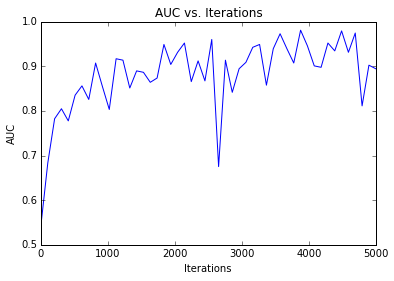

In [9]:
plt.plot(np.linspace(0,5000,50),auc_list)
plt.title('AUC vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('AUC')

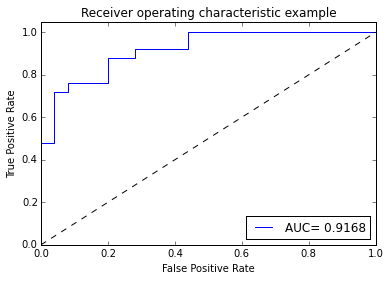

In [21]:
auc_batch = generate_batch_mnist(50, 'validation')
d1 = h_fc1_flat.eval(feed_dict={x:auc_batch[0], y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
d1_norm = h_fc1_norm.eval(feed_dict={x:auc_batch[0], y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})

d2 = h_fc1_flat.eval(feed_dict={x:auc_batch[1], y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
d2_norm = h_fc1_norm.eval(feed_dict={x:auc_batch[1], y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})

distance = np.sum(np.multiply(d1, d2), axis=1)/d1_norm*d2_norm
fpr, tpr, _ = roc_curve(auc_batch[2], distance)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC= '+str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")